In [1]:
from __init__ import *
import utils as _U
reload(_U)
import dataset as _D
reload(_D)
import model as _M
reload(_M)
import train as _T
reload(_T)
import test as _TE
reload(_TE)
import inference as _I
reload(_I)


<module 'inference' from 'E:\\Pycharm_files\\Pycharm_items\\others\\Image2Trend\\inference.py'>

## Training Settings

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
with open('configs/I20R5/I20R5_09-11.yml', 'r') as f:
    setting = _U.Dict2ObjParser(yaml.safe_load(f)).parse()

In [4]:
if 'models' not in os.listdir('./'):
    os.system('mkdir models')
if setting.TRAIN.MODEL_SAVE_FILE.split('/')[1] not in os.listdir('./models/'):
    os.system(f"cd models && mkdir {setting.TRAIN.MODEL_SAVE_FILE.split('/')[1]}")
if 'logs' not in os.listdir('./'):
    os.system('mkdir logs')
if setting.TRAIN.LOG_SAVE_FILE.split('/')[1] not in os.listdir('./logs/'):
    os.system(f"cd logs && mkdir {setting.TRAIN.LOG_SAVE_FILE.split('/')[1]}")

## Train & Valid

### Dataset Preparation

In [5]:
train_dataset = _D.ImageDataSet(win_size = setting.DATASET.LOOKBACK_WIN, \
                            start_date = setting.DATASET.START_DATE, \
                            end_date = setting.DATASET.END_DATE, \
                            mode = 'train', \
                            label = setting.TRAIN.LABEL, \
                            indicators = setting.DATASET.INDICATORS, \
                            show_volume = setting.DATASET.SHOW_VOLUME, \
                            parallel_num=setting.DATASET.PARALLEL_NUM)

[Load Data]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [6]:
train_loader, valid_loader = train_dataset.generate_images(setting.DATASET.SAMPLE_RATE)

Generating Images (sample rate: 0.2): 100%|██████████| 2283/2283 [01:18<00:00, 29.09it/s] 


LABEL: RET5
	Before Resample: 0: 24356/52110, 1: 27754/52110
	Resampled ImageSet: 0: 26785/55508, 1: 28723/55508


In [7]:
# train_loader_size = int(len(image_set)*(1-setting.TRAIN.VALID_RATIO))
# valid_loader_size = len(image_set) - train_loader_size
# 
# train_loader, valid_loader = torch.utils.data.random_split(image_set, [train_loader_size, valid_loader_size])

train_loader = torch.utils.data.DataLoader(dataset=train_loader, batch_size=setting.TRAIN.BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_loader, batch_size=setting.TRAIN.BATCH_SIZE, shuffle=True)

### Model Structure

In [8]:
model_d20 = _M.CNN20d()
model_d20.to(device)

CNN20d(
  (conv1): Sequential(
    (Conv): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(3, 1), dilation=(2, 1))
    (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (Conv): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(3, 1))
    (BN): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (Conv): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (BN): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (DropOut): Dropout(p=0.5

### Training Process

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_d20.parameters(), lr=setting.TRAIN.LEARNING_RATE, weight_decay=setting.TRAIN.WEIGHT_DECAY)

In [10]:
train_loss_set, valid_loss_set, train_acc_set, valid_acc_set = _T.train_n_epochs(setting.TRAIN.NEPOCH, model_d20, setting.TRAIN.LABEL, train_loader, valid_loader, criterion, optimizer, setting.TRAIN.MODEL_SAVE_FILE, setting.TRAIN.EARLY_STOP_EPOCH)

Epoch: 1 Training Loss: 1.016851 Validation Loss: 0.791567 Training Acc: 0.52079 Validation Acc: 0.49081
Validation loss decreased (inf --> 0.791567).  Saving model ...
Epoch: 2 Training Loss: 0.945710 Validation Loss: 0.798215 Training Acc: 0.53657 Validation Acc: 0.49208
Epoch: 3 Training Loss: 0.889222 Validation Loss: 0.755985 Training Acc: 0.55025 Validation Acc: 0.50495
Validation loss decreased (0.791567 --> 0.755985).  Saving model ...
Epoch: 4 Training Loss: 0.855626 Validation Loss: 0.758095 Training Acc: 0.55441 Validation Acc: 0.50777
Epoch: 5 Training Loss: 0.827048 Validation Loss: 0.747424 Training Acc: 0.56394 Validation Acc: 0.51147
Validation loss decreased (0.755985 --> 0.747424).  Saving model ...
Epoch: 6 Training Loss: 0.797996 Validation Loss: 0.751255 Training Acc: 0.56961 Validation Acc: 0.51636
Epoch: 7 Training Loss: 0.775118 Validation Loss: 0.734675 Training Acc: 0.57662 Validation Acc: 0.52161
Validation loss decreased (0.747424 --> 0.734675).  Saving mode

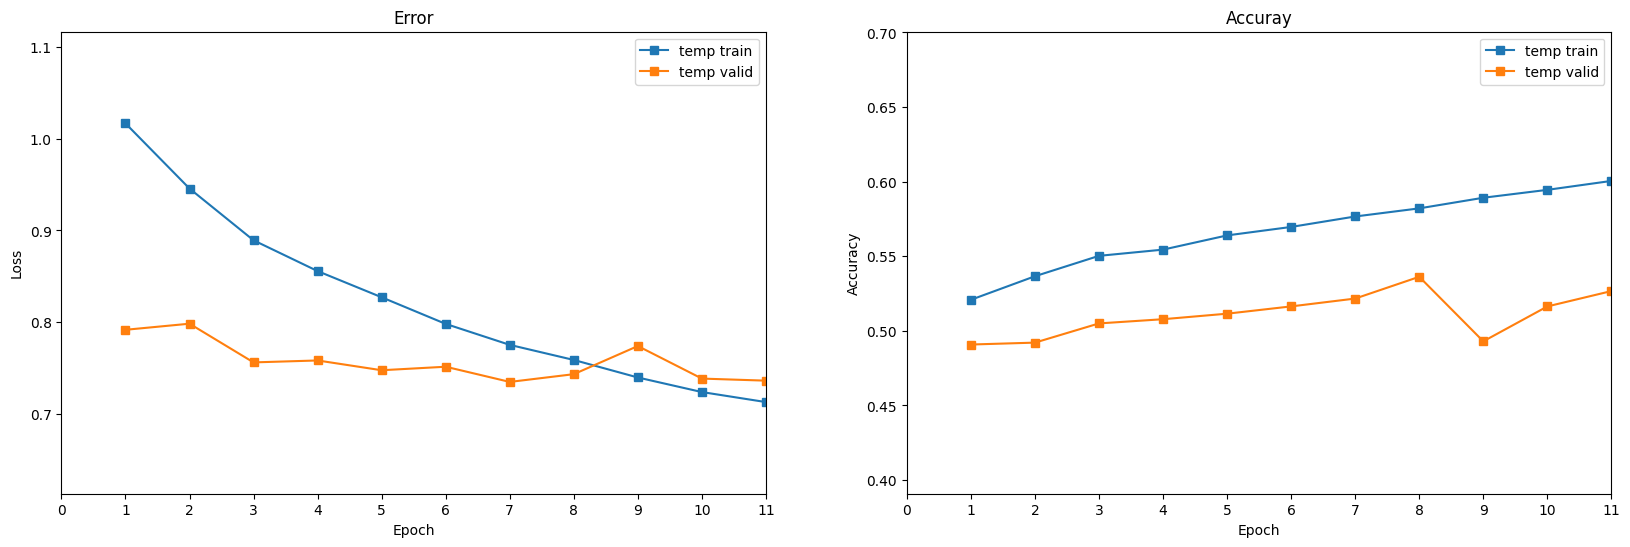

In [11]:
_T.plot_loss_and_acc({"temp train": [train_loss_set, train_acc_set], \
                    "temp valid": [valid_loss_set, valid_acc_set]})

In [12]:
log = pd.DataFrame([train_loss_set, train_acc_set, valid_loss_set, valid_acc_set], index=['train_loss', 'train_acc', 'valid_loss', 'valid_acc'])
log.to_csv(setting.TRAIN.LOG_SAVE_FILE)

In [13]:
logs = pd.read_csv(setting.TRAIN.LOG_SAVE_FILE, index_col=0).T

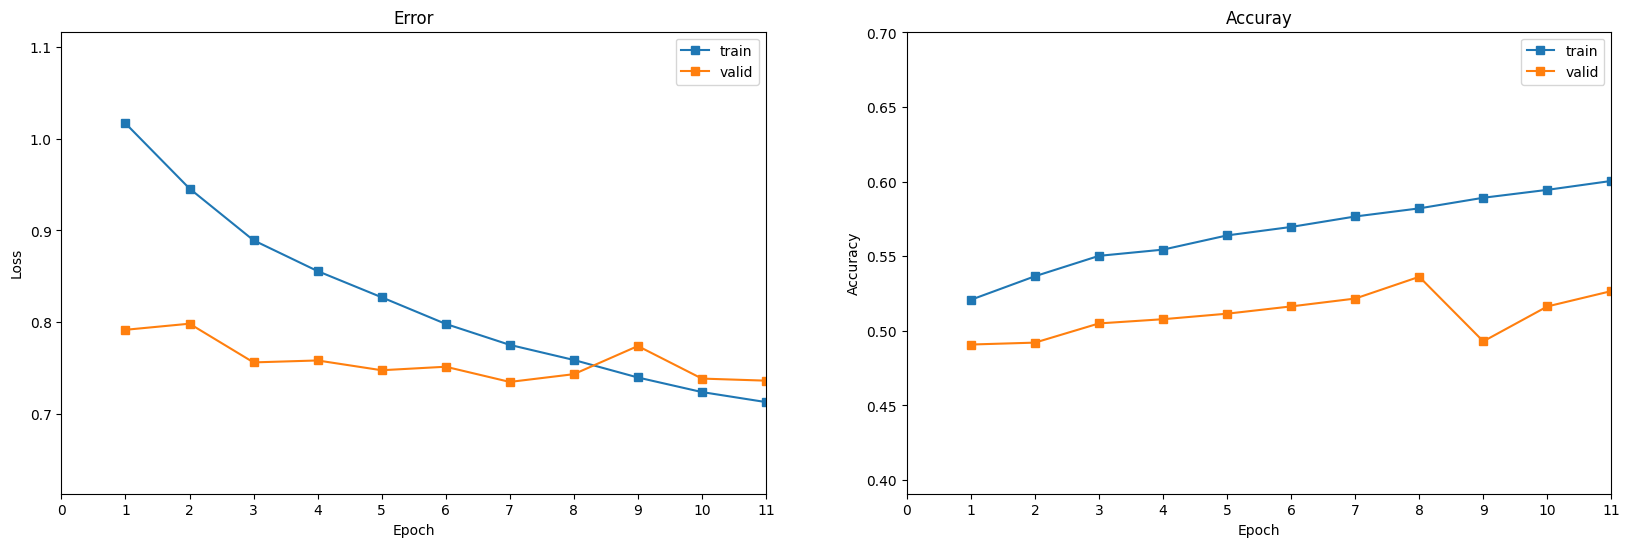

In [14]:
_T.plot_loss_and_acc({"train": [logs['train_loss'], logs['train_acc']], \
                    "valid": [logs['valid_loss'], logs['valid_acc']]})

## Test

In [15]:
model_best =  _M.CNN20d()
model_best.to(device)

# Load Model
state_dict = torch.load(setting.TRAIN.MODEL_SAVE_FILE)
model_best.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [16]:
criterion = nn.BCELoss()
_TE.model_test(model_best, setting.TRAIN.LABEL, ['down', 'up'], criterion, setting)

Testing: 20111231 - 20120401
[Load Data]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Generating Images (sample rate: 1.0): 100%|██████████| 2309/2309 [00:35<00:00, 64.56it/s]


Testing: 20120401 - 20120701
[Load Data]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Generating Images (sample rate: 1.0): 100%|██████████| 2368/2368 [00:36<00:00, 64.63it/s]


Testing: 20120701 - 20121001
[Load Data]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Generating Images (sample rate: 1.0): 100%|██████████| 2428/2428 [00:43<00:00, 56.27it/s]


Testing: 20121001 - 20121231
[Load Data]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Generating Images (sample rate: 1.0): 100%|██████████| 2453/2453 [00:39<00:00, 62.69it/s]


Test Loss: 0.748647

Test Accuracy of  down: 57% (109817/189453)
Test Accuracy of    up: 43% (84857/193855)

Test Accuracy (Overall): 50% (194674/383308)


## Inference

In [17]:
up_factors = _I.model_inference(model_best, setting)

Inferencing: 20111231 - 20120401
[Load Data]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Generating Images (sample rate: 1.0): 100%|██████████| 2309/2309 [00:32<00:00, 71.32it/s]


Inferencing: 20120401 - 20120701
[Load Data]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Generating Images (sample rate: 1.0): 100%|██████████| 2368/2368 [00:34<00:00, 68.43it/s]


Inferencing: 20120701 - 20121001
[Load Data]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Generating Images (sample rate: 1.0): 100%|██████████| 2428/2428 [00:41<00:00, 57.91it/s]


Inferencing: 20121001 - 20121231
[Load Data]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Generating Images (sample rate: 1.0): 100%|██████████| 2453/2453 [00:39<00:00, 61.42it/s]


In [18]:
if 'factors' not in os.listdir('./'):
    os.system('mkdir factors')
if setting.INFERENCE.FACTORS_SAVE_FILE.split('/')[1] not in os.listdir('./factors/'):
    os.system(f"cd factors && mkdir {setting.INFERENCE.FACTORS_SAVE_FILE.split('/')[1]}")
up_factors.to_csv(setting.INFERENCE.FACTORS_SAVE_FILE)